In [2]:
cat AFAD-Full.tar.xz* > AFAD-Full.tar.xz

In [3]:
# Required imports:
import tarfile
# Open the Images tar file:
images_tar = tarfile.open('AFAD-Full.tar.xz')
# Excrat the compressed file:
images_tar.extractall()

In [1]:
# Required imports:
import dlib
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
import shutil

In [2]:
# Required imports:
import face_detection
import face_swap
from face_detection import select_face, select_all_faces
from face_swap import face_swap
from random import randint
import os
import matplotlib.pyplot as plt
%matplotlib inline
import faceBlendCommon as fbc

In [3]:
# Folder Existance Checking and Creating
root_path = './'

orig_path = os.path.join(root_path, 'AFAD-Full')
face_swap_path = os.path.join(root_path, 'AFAD-Full-Faceswap')
lips_aug_path = os.path.join(root_path,'AFAD-Full-Lipstick')
eyecolor_aug_path = os.path.join(root_path,'AFAD-Full-EyeColor')
glass_aug_path = os.path.join(root_path,'AFAD-Full-Glass')

if not os.path.exists(orig_path):
    raise ValueError(f'Original image path {orig_path} does not exist.')

if not os.path.exists(face_swap_path):
    os.mkdir(face_swap_path)
    
if not os.path.exists(lips_aug_path):
    os.mkdir(lips_aug_path)
    
if not os.path.exists(eyecolor_aug_path):
    os.mkdir(eyecolor_aug_path)

if not os.path.exists(glass_aug_path):
    os.mkdir(glass_aug_path)

In [24]:
# Imports

import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import sys

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms
from PIL import Image

In [5]:
!nvidia-smi

Sun Aug 14 07:43:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0 Off |                  N/A |
| 25%   43C    P8    13W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:65:00.0 Off |                  N/A |
| 28%   

In [25]:
torch.backends.cudnn.deterministic = True

TRAIN_CSV_PATH = 'afad_train.csv'
TEST_CSV_PATH = 'afad_test.csv'
VALID_CSV_PATH = 'afad_valid.csv'
IMAGE_PATH = 'AFAD-Full'

In [26]:
##########################
# SETTINGS
##########################

# Hyperparameters
learning_rate = 0.0005
num_epochs = 50

# Architecture
NUM_CLASSES = 26
BATCH_SIZE = 256
GRAYSCALE = False

NUM_WORKERS = 3

In [27]:
###################
# Dataset
###################


class AFADDatasetAge(Dataset):
    """Custom Dataset for loading AFAD face images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_paths = df['path']
        self.y = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_paths[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]


custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
                                       #transforms.RandomRotation(15),
                                       #transforms.RandomHorizontalFlip(0.7),
                                       #transforms.RandomVerticalFlip(0.6),
                                       #transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
                                       transforms.ToTensor()])

train_dataset = AFADDatasetAge(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform)


custom_transform2 = transforms.Compose([transforms.Resize((128, 128)),
                                        transforms.CenterCrop((120, 120)),
                                        transforms.ToTensor()])

test_dataset = AFADDatasetAge(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=custom_transform2)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [28]:
##########################
# MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [29]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
RANDOM_SEED = 0

In [33]:
###########################################
# Initialize Cost, Model, and Optimizer
###########################################

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
def compute_mae_and_mse(model, data_loader, device):
    mae, mse, num_examples = 0., 0., 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        mae += torch.sum(torch.abs(predicted_labels - targets))
        mse += torch.sum((predicted_labels - targets)**2)
    
    mae = mae.float()/num_examples
    mse = mse.float()/num_examples
       
    return mae, mse

In [ ]:
PATH = 'Model'
start_time = time.time()
train_rmse_lst = []
train_mae_lst = []
test_rmse_lst = []
test_mae_lst = []

best_mae, best_rmse, best_epoch = 999, 999, -1
for epoch in range(num_epochs):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        if not batch_idx % 50:
            s = ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                 % (epoch+1, num_epochs, batch_idx,
                     len(train_dataset)//BATCH_SIZE, cost))
            print(s)
            #with open(LOGFILE, 'a') as f:
                #f.write('%s\n' % s)

    model.eval()
    with torch.set_grad_enabled(False):
        #train_mae, train_mse = compute_mae_and_mse(model, train_loader,device=device)
        test_mae, test_mse = compute_mae_and_mse(model, test_loader,
                                                device=device)

    if test_mae < best_mae:
        best_mae, best_rmse, best_epoch = test_mae, torch.sqrt(test_mse), epoch
        ########## SAVE MODEL #############
        torch.save(model.state_dict(), os.path.join(PATH, 'best_afad_photo_model.pt'))


    s = 'MAE/RMSE: | Current Test: %.2f/%.2f Ep. %d | Best Test : %.2f/%.2f Ep. %d' % (
        test_mae, torch.sqrt(test_mse), epoch, best_mae, best_rmse, best_epoch)
    #train_rmse_lst.append(torch.sqrt(train_mse))
    #train_mae_lst.append(train_mae)
    test_rmse_lst.append(torch.sqrt(test_mse))
    test_mae_lst.append(test_mae)
    print(s)
    #with open(LOGFILE, 'a') as f:
        #f.write('%s\n' % s)

    s = 'Time elapsed: %.2f min' % ((time.time() - start_time)/60)
    print(s)
    #with open(LOGFILE, 'a') as f:
        #f.write('%s\n' % s)

Epoch: 001/050 | Batch 0000/0462 | Cost: 3.0988
Epoch: 001/050 | Batch 0050/0462 | Cost: 2.8797
Epoch: 001/050 | Batch 0100/0462 | Cost: 2.8556
Epoch: 001/050 | Batch 0150/0462 | Cost: 2.8582
Epoch: 001/050 | Batch 0200/0462 | Cost: 2.8100
Epoch: 001/050 | Batch 0250/0462 | Cost: 2.7598
Epoch: 001/050 | Batch 0300/0462 | Cost: 2.7673
Epoch: 001/050 | Batch 0350/0462 | Cost: 2.9162
Epoch: 001/050 | Batch 0400/0462 | Cost: 2.7399
Epoch: 001/050 | Batch 0450/0462 | Cost: 2.8470
MAE/RMSE: | Current Test: 4.79/6.67 Ep. 0 | Best Test : 4.79/6.67 Ep. 0
Time elapsed: 4.74 min
Epoch: 002/050 | Batch 0000/0462 | Cost: 2.7201
Epoch: 002/050 | Batch 0050/0462 | Cost: 2.8167
Epoch: 002/050 | Batch 0100/0462 | Cost: 2.7502
Epoch: 002/050 | Batch 0150/0462 | Cost: 2.8153
Epoch: 002/050 | Batch 0200/0462 | Cost: 2.7414
Epoch: 002/050 | Batch 0250/0462 | Cost: 2.7648
Epoch: 002/050 | Batch 0300/0462 | Cost: 2.7758
Epoch: 002/050 | Batch 0350/0462 | Cost: 2.6564
Epoch: 002/050 | Batch 0400/0462 | Cost: 

Text(0.5,1,'RMSE & MAE')

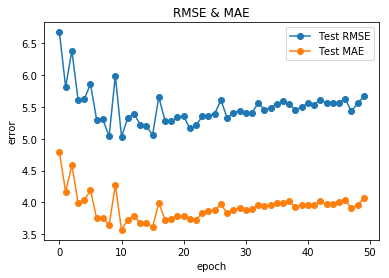

In [37]:
#plt.plot(train_rmse_lst,'-o')
#plt.plot(train_mae_lst,'-o')
plt.plot(test_rmse_lst,'-o')
plt.plot(test_mae_lst,'-o')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(['Test RMSE','Test MAE'])
plt.title('RMSE & MAE')

In [38]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

    train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                               device=device)
    test_mae, test_mse = compute_mae_and_mse(model, test_loader,
                                             device=device)

    s = 'MAE/RMSE: | Train: %.2f/%.2f | Test: %.2f/%.2f' % (
        train_mae, torch.sqrt(train_mse), test_mae, torch.sqrt(test_mse))
    print(s)
    #with open(LOGFILE, 'a') as f:
        #f.write('%s\n' % s)

s = 'Total Training Time: %.2f min' % ((time.time() - start_time)/60)
print(s)
#with open(LOGFILE, 'a') as f:
    #f.write('%s\n' % s)

MAE/RMSE: | Train: 0.33/1.53 | Test: 4.06/5.66
Total Training Time: 265.62 min


In [39]:
########## EVALUATE BEST MODEL ######
model.load_state_dict(torch.load(os.path.join(PATH, 'best_afad_photo_model.pt')))
model.eval()

with torch.set_grad_enabled(False):
    train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                               device=device)
    #valid_mae, valid_mse = compute_mae_and_mse(model, valid_loader,device=device)
    test_mae, test_mse = compute_mae_and_mse(model, test_loader,
                                             device=device)

    s = 'MAE/RMSE: | Best Train: %.2f/%.2f | Best Test: %.2f/%.2f' % (
        train_mae, torch.sqrt(train_mse),
        #valid_mae, torch.sqrt(valid_mse),
        test_mae, torch.sqrt(test_mse))
    print(s)

MAE/RMSE: | Best Train: 2.99/4.34 | Best Test: 3.57/5.03


In [40]:
PATH = 'Model'
model.load_state_dict(torch.load(os.path.join(PATH, 'best_afad_photo_model.pt')))
model.eval()
tgt = []
pred = []
with torch.set_grad_enabled(False):
    for batch_idx,(features,targets) in enumerate(test_loader):
        features = features.to(device)
        targets = targets.to(device)
        tgt.append(targets.flatten().tolist())
        #print(targets)
        logits, probas = model(features)
        _,predicted_labels = torch.max(probas, 1)
        pred.append(predicted_labels.flatten().tolist())

In [41]:
# Accuracy Calculation
count = 0
for i in range(127):
    for j in range(255):
        if tgt[i][j] == pred[i][j]:
            count = count + 1
print(count/(128*256))       

0.118927001953125


In [42]:
import pandas as pd
from itertools import chain,groupby
pred_list = list(chain.from_iterable(pred))
tgt_list = list(chain.from_iterable(tgt))
df = pd.DataFrame(list(zip(tgt_list, pred_list)),
               columns =['Original_Label', 'Predicted_Label'])
df.to_csv(r'Prediction_AFAD_Photo.csv', index = False)

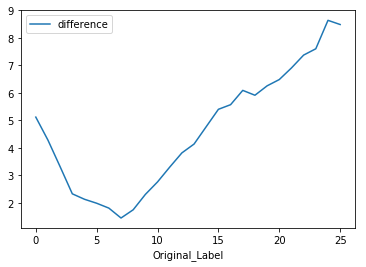

In [43]:
df2 = pd.read_csv('Prediction_Difference_AFAD_Photo.csv')
df2.groupby(['Original_Label']).mean().plot()